**Step 1.** Load the libraries
*Data Handling:* pandas, numpy, resample, and SMOTE for preprocessing and balancing datasets.

*Modeling:* tensorflow.keras modules for neural network architecture and training. SimpleRNN simulating the Elman Neural Network structure.

*Reinforcement Learning:* Deque, random, and custom Deep Q-Network setup using Keras and TensorFlow.

*Visualization:* matplotlib and seaborn for exploratory data analysis and results plotting.

*Utilities:* Warning suppression for cleaner output.

In [11]:
#==============Load the desired Libraries==================
# ---Data Handling and Preprocessing ---
import pandas as pd          # For reading and managing datasets
import numpy as np           # For numerical computations and array handling
from sklearn.utils import resample  # For up/down sampling datasets
from imblearn.over_sampling import SMOTE

# --- Elman Neural Network (Simple RNN as ENN) ---
from tensorflow.keras.layers import SimpleRNN  # For Elman-style recurrent layers

# --- Deep Q-Learning Requirements ---
import random                # For random action selection in exploration
from collections import deque  # For experience replay memory
import tensorflow as tf      # TensorFlow backend for building DQN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# --- Plotting and Visualization ---
import matplotlib.pyplot as plt   # For line plots, bar charts, etc.
import seaborn as sns            # For enhanced statistical plots
from matplotlib.lines import Line2D

# --- Utility ---
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for clean output

**Step 2.**
*Load dataset:* Load the individual datasets and evaluate the features in each dataset, including any overlapping features. 

In [12]:
# ---Load the dataset File Paths ---
field_data_path = "/Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/Crop_recommendation.csv"
greenhouse_data_path = "/Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/IoTProcessed_Data.csv"

# ---Load Datasets ---
df_field = pd.read_csv(field_data_path)
df_greenhouse = pd.read_csv(greenhouse_data_path)

# ---Identify Overlapping and Distinct Features ---
# Get feature (column) names
field_features = set(df_field.columns)
greenhouse_features = set(df_greenhouse.columns)

# Find overlapping features
overlapping_features = field_features.intersection(greenhouse_features)

# Find distinct features
field_only_features = field_features - greenhouse_features
greenhouse_only_features = greenhouse_features - field_features

# --- Print the results ---
print("Overlapping Features:")
print(overlapping_features)

print("\n Features Only in Field Dataset:")
print(field_only_features)

print("\n Features Only in Greenhouse Dataset:")
print(greenhouse_only_features)

Overlapping Features:
{'K', 'humidity', 'P', 'temperature', 'N'}

 Features Only in Field Dataset:
{'rainfall', 'label', 'ph'}

 Features Only in Greenhouse Dataset:
{'Fan_actuator_OFF', 'Fan_actuator_ON', 'Water_pump_actuator_ON', 'Watering_plant_pump_ON', 'date', 'Watering_plant_pump_OFF', 'water_level', 'Water_pump_actuator_OFF'}


**Step 3.**
*Feature Mapping:* Perform feature mapping

In [13]:
# ---Perform Feature Matching Strategy ---

# Select relevant features from the field dataset
field_selected = df_field[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']].copy()

# Create binary columns for actuators in the greenhouse dataset
# Fan Activator: ON = 1, OFF = 0
df_greenhouse['Fan_Activator'] = df_greenhouse['Fan_actuator_ON']

# Water Pump Activator (watering pump): ON = 1, OFF = 0
df_greenhouse['Water_Pump'] = df_greenhouse['Watering_plant_pump_ON']

# Select relevant features from the greenhouse dataset
greenhouse_selected = df_greenhouse[['date', 'N', 'P', 'K', 'temperature', 'humidity',
                                     'water_level', 'Fan_Activator', 'Water_Pump']].copy()

# --- Preview the selected features ---
print("Field Dataset (Selected Features):")
print(field_selected.head())

print("\n Greenhouse Dataset (Selected Features with Binary Actuators):")
print(greenhouse_selected.head())



Field Dataset (Selected Features):
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

 Greenhouse Dataset (Selected Features with Binary Actuators):
              date    N    P    K  temperature  humidity  water_level  \
0  08/02/2024 6:10  255  255  255           41        63          100   
1  08/02/2024 6:15  255  255  255           41        59          100   
2  08/02/2024 6:20  255  255  255           41        62          100   
3  08/02/2024 6:05  255  255  255           40        60          100   
4  08/02/2024 6:00  255  255  255           39        61          100   

   Fan_Activator  Water_Pump  
0              1           0  
1   

**Step 4.**
*Combined Dataset:* Perform combining the datasets into combined dataset.

In [14]:
# --- Perform the Combination Method ---
# Ensure column names are stripped of whitespace
df_greenhouse.columns = df_greenhouse.columns.str.strip()

# 1. Create a cleaned greenhouse dataset with matched features
greenhouse_cleaned = df_greenhouse[['date', 'water_level', 'Fan_Activator', 'Water_Pump']].copy()

# 2. Sample greenhouse data to match the size of the field dataset
# Randomly sample with replacement to preserve 37,922 rows
greenhouse_sampled = greenhouse_cleaned.sample(n=len(field_selected), replace=True, random_state=42).reset_index(drop=True)

# 3. Reset index on field data for alignment
field_selected_reset = field_selected.reset_index(drop=True)

# 4. Concatenate horizontally
combined_dataset = pd.concat([field_selected_reset, greenhouse_sampled], axis=1)

# 5. Preview the final dataset
print("Combined Dataset Shape:", combined_dataset.shape)
print(combined_dataset.head())


Combined Dataset Shape: (2200, 12)
    N   P   K  temperature   humidity        ph    rainfall label  \
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice   
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice   
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice   
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice   
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice   

              date  water_level  Fan_Activator  Water_Pump  
0  02/02/2024 0:45          100              0           0  
1  30/12/2023 6:41          100              1           0  
2  11/01/2024 1:18          100              1           1  
3  12/01/2024 6:15           75              1           1  
4  13/01/2024 8:43            0              0           0  


**Step 5.**
*Abbrivation:* Make the abbrivations for the features and display the abbrivations.

In [15]:
# --- Perform Abbreviation Map ---
abbreviation_map = {
    'Nitrogen': 'N',
    'Phosphorus': 'P',
    'Potassium': 'K',
    'Temperature': 'Temp',
    'temperature': 'Temp',
    'Humidity': 'H',
    'humidity': 'H',
    'Potential of hydrogen': 'pH',
    'ph': 'pH',
    'Rainfall': 'R',
    'rainfall': 'R',
    'Date and time': 'DT',
    'date': 'DT',
    'water_level': 'WL',
    'Water Level': 'WL',
    'Fan_Activator': 'FA',
    'Water_Pump': 'WP',
    'label': 'label'  # Keep label as it is
}

# ---Rename columns (only if needed) ---
# Preserve already abbreviated columns like N, P, K
combined_dataset.rename(columns=lambda col: abbreviation_map.get(col, col), inplace=True)

# ---Preview the renamed columns ---
print("Renamed Combined Dataset Columns:")
print(combined_dataset.columns.tolist())


Renamed Combined Dataset Columns:
['N', 'P', 'K', 'Temp', 'H', 'pH', 'R', 'label', 'DT', 'WL', 'FA', 'WP']


**Step 6.**
*Synthesizing Crop Health (CH) Feature:* Implement the score-based threshold criteria using environmental variables and agronomic domain knowledge to synthesize the Crop_Health (CH) field in the combined dataset. Moreover, check the class imbalance.

Crop Health Classification Added:
    N   P   K       Temp          H        pH           R   WL  CH
0  90  42  43  20.879744  82.002744  6.502985  202.935536  100   0
1  85  58  41  21.770462  80.319644  7.038096  226.655537  100   0
2  60  55  44  23.004459  82.320763  7.840207  263.964248  100   0
3  74  35  40  26.491096  80.158363  6.980401  242.864034   75   0
4  78  42  42  20.130175  81.604873  7.628473  262.717340    0   0


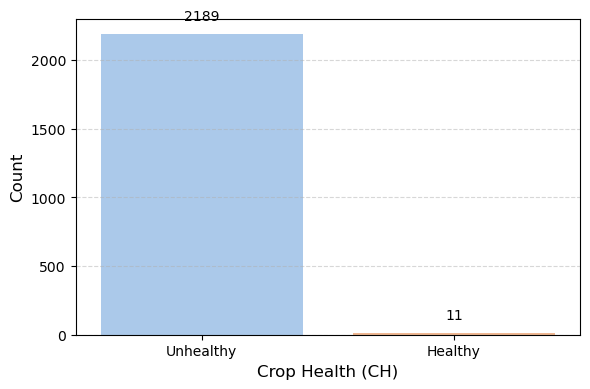

In [16]:
# --- Function to classify Crop Health based on agronomic guidelines ---
def classify_crop_health(row):
    score = 0

    # Nitrogen: 90–150 mg/kg
    if 90 <= row['N'] <= 150:
        score += 1

    # Phosphorus: 15–30 mg/kg
    if 15 <= row['P'] <= 30:
        score += 1

    # Potassium: 100–200 mg/kg
    if 100 <= row['K'] <= 200:
        score += 1

    # Temperature: 20–30 °C
    if 20 <= row['Temp'] <= 30:
        score += 1

    # Humidity: 50–70 %
    if 50 <= row['H'] <= 70:
        score += 1

    # pH: 6.3–7.0
    if 6.3 <= row['pH'] <= 7.0:
        score += 1

    # Rainfall: 50–150 mm
    if 50 <= row['R'] <= 150:
        score += 1

    # Water Level: 30–70 (assumed normalized or percent scale)
    if 30 <= row['WL'] <= 70:
        score += 1

    # Define threshold score to be considered healthy (e.g., 6 out of 8)
    return 1 if score >= 6 else 0

# --- Apply classification to the dataset ---
combined_dataset['CH'] = combined_dataset.apply(classify_crop_health, axis=1)

# --- Preview the dataset with Crop Health ---
print("Crop Health Classification Added:")
print(combined_dataset[['N', 'P', 'K', 'Temp', 'H', 'pH', 'R', 'WL', 'CH']].head())

# --- Plot the distribution of Crop Health (CH) classes ---
plt.figure(figsize=(6, 4))
sns.countplot(data=combined_dataset, x='CH', palette='pastel')

# Add annotations
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 100, f'{int(height)}', ha='center')

# Labels and title
#plt.title('Distribution of Crop Health Classes', fontsize=14)
plt.xlabel('Crop Health (CH)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Unhealthy', 'Healthy'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Solid border box around the plot
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

plt.tight_layout()
plt.show()


**Step 7.** 
*SMOTE Analysis:* Perform SMOTE analysis to balance the CH field.

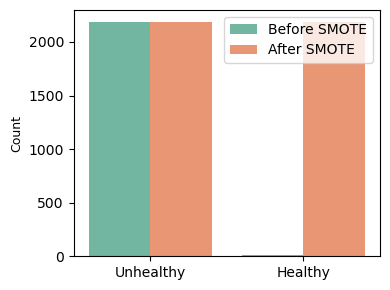

In [17]:


# --- 1. Prepare features and labels ---
X = combined_dataset.drop(columns=['CH'])    # Features
y = combined_dataset['CH']                   # Target

# Keep only numeric columns for SMOTE (drop non-numeric like 'label' or 'DT')
X_numeric = X.select_dtypes(include=['int64', 'float64'])

# --- 2. Apply SMOTE to balance the dataset ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_numeric, y)

# --- 3. Prepare data for visualization ---
before_df = pd.DataFrame({'CH': y, 'Source': 'Before SMOTE'})
after_df = pd.DataFrame({'CH': y_resampled, 'Source': 'After SMOTE'})
plot_df = pd.concat([before_df, after_df], axis=0)

# --- 4. Plot the combined bar chart ---
plt.figure(figsize=(4, 3))
sns.countplot(data=plot_df, x='CH', hue='Source', palette='Set2')

# Customize plot appearance
#plt.xlabel('Crop Health (CH)', fontsize=12)
plt.ylabel('Count', fontsize=9)
plt.xticks(ticks=[0, 1], labels=['Unhealthy', 'Healthy'])
plt.legend(loc='upper right')  # Legend with no title
#plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel('')
# Add solid borders around the plot
for spine in plt.gca().spines.values():
    spine.set_visible(True)

# Final layout
plt.tight_layout()
plt.show()


**Step 8.**
*Pearson Correlationship:* Perform pearson correlationship and plot the relationship among N, P, K, Temp, H, pH, and R.

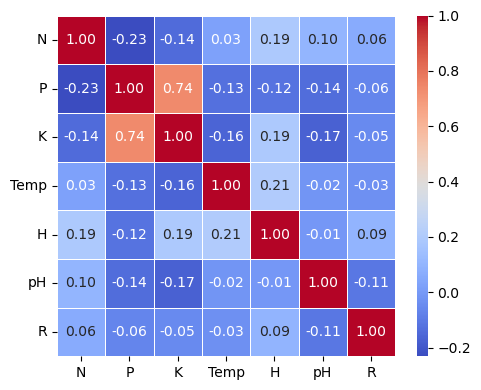

In [8]:

# --- Select relevant features ---
features = ['N', 'P', 'K', 'Temp', 'H', 'pH', 'R']
corr_matrix = combined_dataset[features].corr(method='pearson')

# --- Create heatmap with a proportionally scaled colorbar ---
fig, ax = plt.subplots(figsize=(5, 4))

# Create a heatmap without square cells
heatmap = sns.heatmap(corr_matrix,
                      annot=True,
                      cmap='coolwarm',
                      fmt='.2f',
                      linewidths=0.5,
                      ax=ax,
                      cbar=True,
                      cbar_kws={'aspect': 30})  # Aspect controls height

# Format axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Remove solid border
for spine in ax.spines.values():
    spine.set_visible(False)

# Ensure layout adjusts to include colorbar nicely
plt.tight_layout()
plt.show()


**Step 9.**
*Categprization into Crop and Fruits:* Perform categorization of the label field into crop and fruits.

In [9]:

# --- Define label categories ---
crop_labels = [
    'rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans',
    'mungbean', 'blackgram', 'lentil', 'cotton', 'jute', 'coffee'
]

fruit_labels = [
    'pomegranate', 'banana', 'mango', 'grapes', 'watermelon',
    'muskmelon', 'apple', 'orange', 'papaya', 'coconut'
]

# --- Categorize label field ---
def categorize_label(label):
    label_lower = str(label).strip().lower()
    if label_lower in crop_labels:
        return 'Crop'
    elif label_lower in fruit_labels:
        return 'Fruit'
    else:
        return 'Unknown'

# --- Apply categorization ---
combined_dataset['LabelCategory'] = combined_dataset['label'].apply(categorize_label)

# --- Preview ---
print(combined_dataset[['label', 'LabelCategory']].head())

crop_count = (combined_dataset['LabelCategory'] == 'Crop').sum()
fruit_count = (combined_dataset['LabelCategory'] == 'Fruit').sum()

print(f"Crop count: {crop_count}")
print(f"Fruit count: {fruit_count}")


  label LabelCategory
0  rice          Crop
1  rice          Crop
2  rice          Crop
3  rice          Crop
4  rice          Crop
Crop count: 1200
Fruit count: 1000


**Step 10.**
*Plot Feature Distribution:* Analyze and visualize the distributions of various features with respect to the crop and fruit categories.

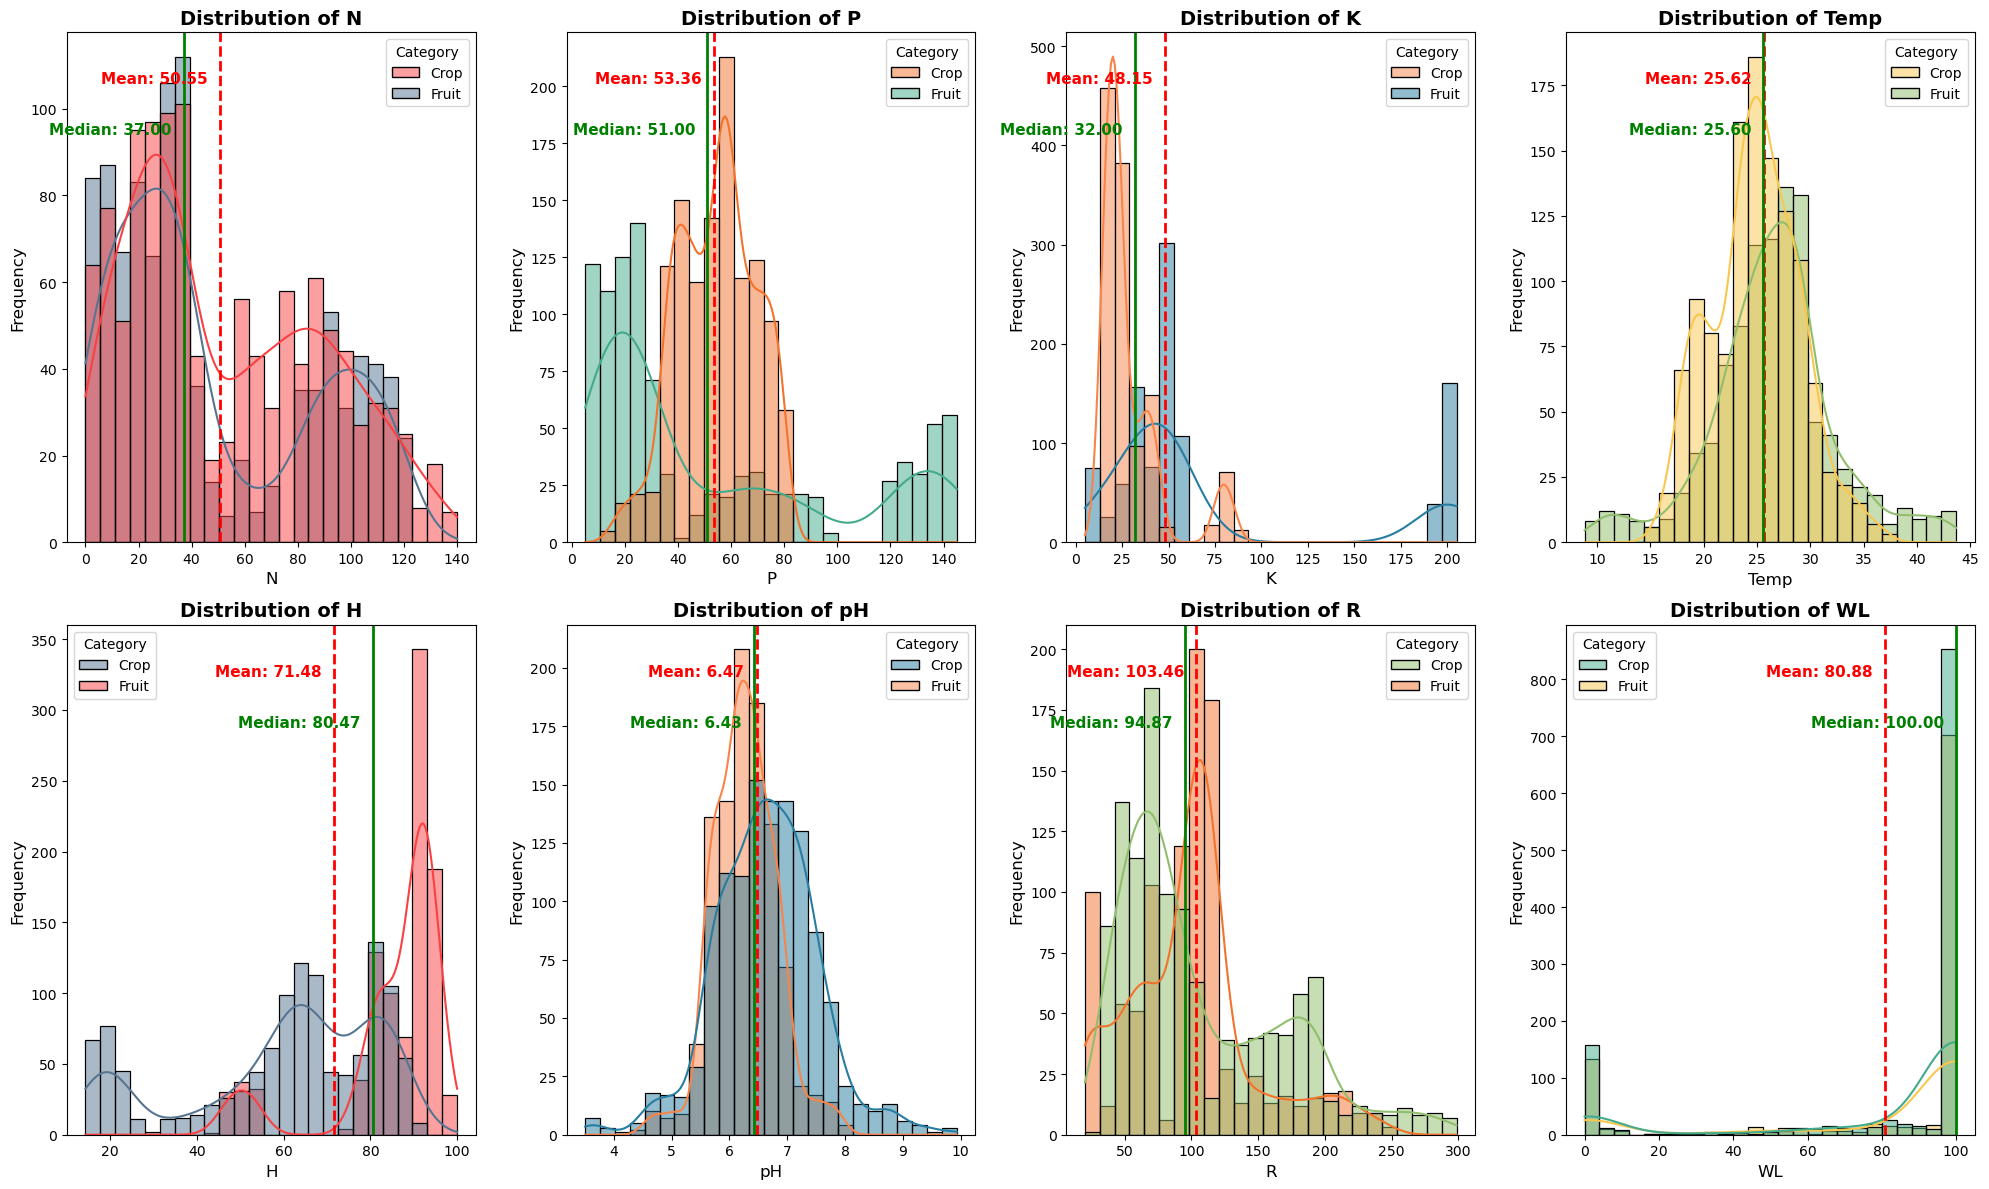

In [10]:
# --- Prepare dataset ---
df = combined_dataset.copy()
df['Category'] = df['LabelCategory']

# --- Define features and custom palettes ---
features_top = ['N', 'P', 'K', 'Temp']
features_bottom = ['H', 'pH', 'R', 'WL']
features_all = features_top + features_bottom

# Define colorful feature-specific palettes
feature_palettes = {
    'N': {'Crop': '#f94144', 'Fruit': '#577590'},
    'P': {'Crop': '#f3722c', 'Fruit': '#43aa8b'},
    'K': {'Crop': '#f9844a', 'Fruit': '#277da1'},
    'Temp': {'Crop': '#f9c74f', 'Fruit': '#90be6d'},
    'H': {'Crop': '#577590', 'Fruit': '#f94144'},
    'pH': {'Crop': '#277da1', 'Fruit': '#f9844a'},
    'R': {'Crop': '#90be6d', 'Fruit': '#f3722c'},
    'WL': {'Crop': '#43aa8b', 'Fruit': '#f9c74f'}
}

# --- Set up GridSpec layout ---
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

# --- Plotting function with safe label placement and color ---
def plot_feature(ax, feature):
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    
    sns.histplot(df, x=feature, hue='Category', bins=25, kde=True,
                 palette=feature_palettes[feature],
                 edgecolor="black", ax=ax)

    ax.axvline(mean_val, color='r', linestyle='--', linewidth=2)
    ax.axvline(median_val, color='g', linestyle='-', linewidth=2)

    xlim = ax.get_xlim()
    offset = (xlim[1] - xlim[0]) * 0.03

    ax.text(mean_val - offset, ax.get_ylim()[1] * 0.9,
            f'Mean: {mean_val:.2f}', color='r', fontsize=11,
            weight='bold', ha='right')
    
    ax.text(median_val - offset, ax.get_ylim()[1] * 0.8,
            f'Median: {median_val:.2f}', color='g', fontsize=11,
            weight='bold', ha='right')

    ax.set_title(f'Distribution of {feature}', fontsize=14, fontweight='bold')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# --- Plot all features ---
for i, feature in enumerate(features_top):
    ax = fig.add_subplot(gs[0, i])
    plot_feature(ax, feature)

for i, feature in enumerate(features_bottom):
    ax = fig.add_subplot(gs[1, i])
    plot_feature(ax, feature)

# --- Custom Legend (unified style) ---
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#f94144', markersize=10, label='Crop'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1e90ff', markersize=10, label='Fruit')
]
#fig.legend(handles=handles, title='Category', fontsize=12, loc='upper right')

# --- Final layout ---
plt.tight_layout()
plt.show()


In [108]:
# --- Define save path ---
greenhouse_data_path = "/Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/Combined_Data.csv"

# --- Save the combined dataset ---
combined_dataset.to_csv(greenhouse_data_path, index=False)

print("Combined dataset saved successfully.")


Combined dataset saved successfully.
